# Input Sampling notebook

---

This notebook is used to create an initial dataset, by sampling from multiple sources from the internet.
The goal is to obtain multiple formats of files that create visual outputs:
- svg
- tikz
- html-css-js
- ascii art
- P5js
- scad

The output will be a huggingface dataset with only image and code(pil image ans str)

## SVG

#### Selected source
- https://huggingface.co/datasets/ServiceNow/svg-emoji
#### Policies
- No \<animate>, \<animateMotion>, \<animateTransform>, \<set>
- No <text>
- At least one of (\<circle>,\<rect>,\<ellipse>,\<polygon>,\<polyline>,\<line>)
- Number of characters > Cmin
- Number of characters < Cmax

#### Statistics

Computing number of <animateMotion  in the svg: 100%|██████████| 8708/8708 [00:00<00:00, 10494.81 examples/s]
Computing number of <animateTransform  in the svg: 100%|██████████| 8708/8708 [00:00<00:00, 9025.82 examples/s] 
computing length of the svg: 100%|██████████| 8708/8708 [00:01<00:00, 8092.04 examples/s]


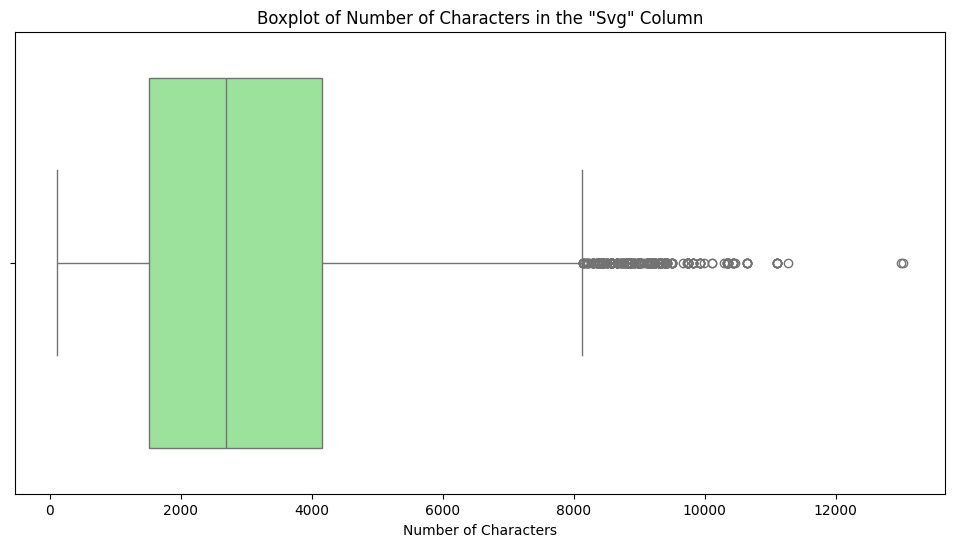

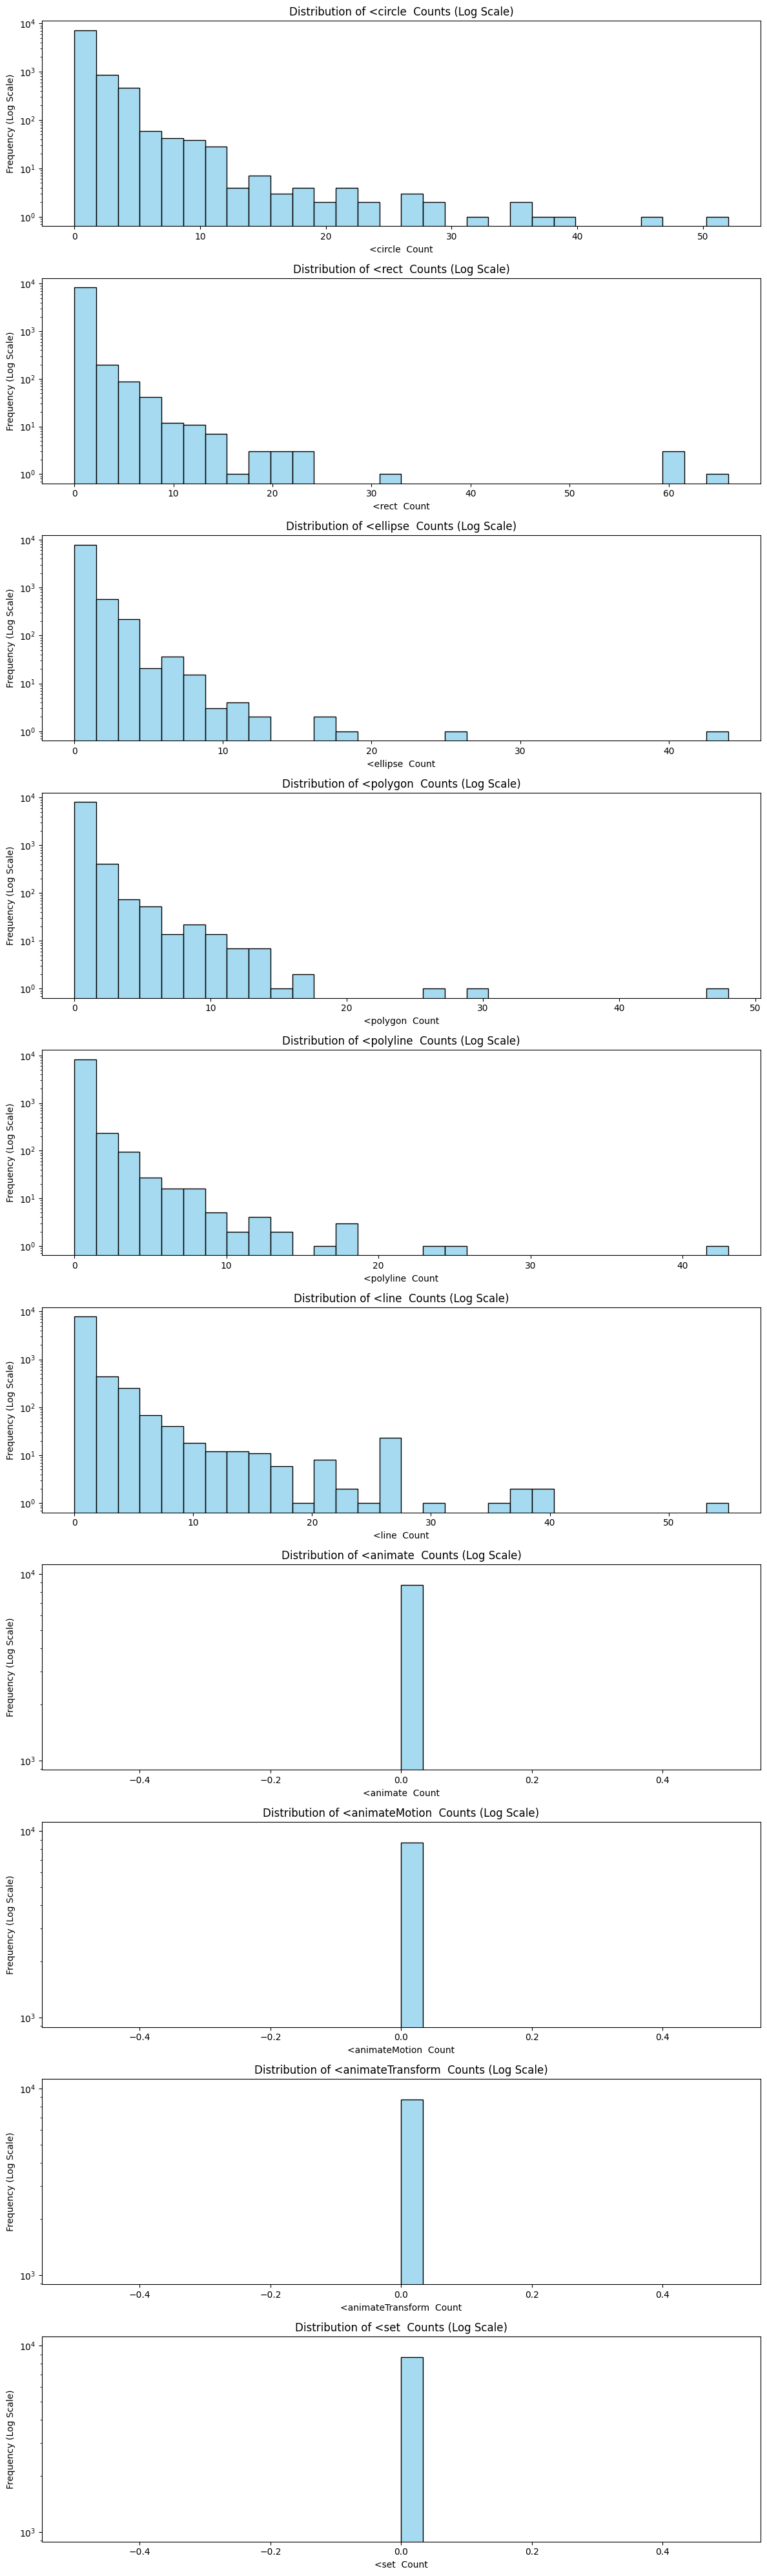

In [14]:
import re
from datasets import load_dataset

from input_utils import SvgFilters

ds_initial = load_dataset("ServiceNow/svg-emoji",split="train")

SvgFilters.statistics(ds_initial)

#### Filtering

In [15]:
ds = ds_initial.filter(SvgFilters.noAnimations, desc="filtering out animated svgs")
ds = ds.filter(SvgFilters.noText, desc="filtering out svgs with texts")
ds = ds.filter(SvgFilters.hasBasicShape, desc="filtering out svgs without basic shapes")
ds = ds.filter(
    SvgFilters.maxCharacters,
    desc="filtering svgs under 4500 caracters and over 500",
)
ds.cleanup_cache_files()

filtering out svgs without basic shapes: 100%|██████████| 8708/8708 [00:00<00:00, 64434.63 examples/s]


14

#### Pushing the current subset

In [25]:
ds = ds.rename_columns({"Filename":"name","Svg":"code"})
ds.push_to_hub("CharlyR/varbench-inputs", config_name="svg", split="auto_filtered")


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/varbench-inputs/commit/fd5acd201139cbd763d9b4506464319f582b5693', commit_message='Upload dataset', commit_description='', oid='fd5acd201139cbd763d9b4506464319f582b5693', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/varbench-inputs', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/varbench-inputs'), pr_revision=None, pr_num=None)

## TIKZ

#### Selected source
- pre-created local dataset
#### Policies
- None?

#### Creating the dataset

In [24]:
import os

print(os.getcwd())
all_sources = []
tikz_dir = "../dataset/tikz"
seen_names = set()

for edit in os.listdir("../dataset/tikz"):
    input_path = os.path.join(tikz_dir, edit, "input.tex")
    name = edit.split("_", 1)[0]
    code = open(input_path).read()
    if name not in seen_names:
        seen_names.add(name)
        all_sources.append({"name": name, "code": code})

all_sources

/home/creux/Documents/AI/VariabilityBenchmark/notebooks


[{'name': 'donkey',
  'code': '\\documentclass[tikz,border=5]{standalone}\n\\usepackage[prefix=]{xcolor-material}\n\n\\tikzset{\n  half clip/.code={\n    \\clip (0, -256) rectangle (256, 256);\n  },\n  color/.code=\\colorlet{fill color}{#1},\n  color alias/.code args={#1 as #2}{\\colorlet{#1}{#2}},\n  on left/.style={.. on left/.style={#1}},\n  on right/.style={.. on right/.style={#1}},\n  split/.style args={#1 and #2}{\n    on left ={color alias=fill color as #1},\n    on right={color alias=fill color as #2, half clip}\n  }\n}\n\\newcommand\\reflect[2][]{\n\\begin{scope}[#1]\\foreach \\side in {-1, 1}{\\begin{scope}\n\\ifnum\\side=-1 \\tikzset{.. on left/.try}\\else\\tikzset{.. on right/.try}\\fi\n\\begin{scope}[xscale=\\side]#2\\end{scope}\n\\end{scope}}\\end{scope}}\n\n\\tikzset{\ndonkey/.pic={\n\\begin{scope}[x=3cm/480,y=3cm/480]\n\\reflect[\n  on left ={color alias=ears as BlueGrey500},\n  on right={color alias=ears as BlueGrey700},\n  outer ear/.style={fill=ears}, inner ear/.styl

#### Statistics

In [ ]:
#TODO

#### Pushing the current subset

In [27]:
import datasets
import pandas as pd
ds = datasets.Dataset.from_pandas(pd.DataFrame(data=all_sources))
ds.push_to_hub("CharlyR/varbench-inputs", config_name="tikz", split="auto_filtered")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/varbench-inputs/commit/5535b3123899fc1acfd0cacc587d26c7d64ea644', commit_message='Upload dataset', commit_description='', oid='5535b3123899fc1acfd0cacc587d26c7d64ea644', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/varbench-inputs', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/varbench-inputs'), pr_revision=None, pr_num=None)

## P5js

#### Selected source
- https://happycoding.io/tutorials/p5js/ ?
- https://openprocessing.org/discover/#/trending
#### treatment
- Comments removal
#### Policies
- handpicked example from the sites